# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics
from math import floor

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [3]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

In [5]:
# Get random training images and show them.
images, labels = iter(train_loader).next()
show_image(torchvision.utils.make_grid(images))

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [ ]:
channels = 3
height, width = 32, 32
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes, padding=1, kernelHeight=2, stride=1):
        super().__init__()
        self.first = True
        self.num_classes = num_classes
        activation_fn = nn.ReLU
        outHeight = floor((height + padding*2 - (kernelHeight - 1) - 1)/stride) + 1
        outWidth = floor((width + padding*2 - (kernelHeight - 1)  - 1)/stride) + 1
        n_features = 432
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=1 + kernelHeight*2, stride=stride, padding=padding),
            nn.MaxPool2d((2,2), (2,2)),
            activation_fn(),
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=1 + kernelHeight*2, stride=stride, padding=padding),
            nn.MaxPool2d((2,2), (2,2)),
            activation_fn(),
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=1 + kernelHeight*2, stride=stride, padding=padding),
            activation_fn(),

            nn.Flatten(),  # from (1, channels, height, width) to (1, channels * height * width)
            nn.Linear(n_features, n_features//2),
            activation_fn(),
            nn.Linear(n_features//2, n_features//4),
            activation_fn(),
            nn.Linear(n_features//4, num_classes),
            # nn.Softmax(num_classes)
        )

    def forward(self, x):
        return self.net(x)


model = Model(n_classes)
device = torch.device('cpu')  # use cuda or cpu
model.to(device)
print(model)

## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [23]:
loss_fn = nn.CrossEntropyLoss()  # Your code here!
optimizer = optim.Adam(model.parameters(), lr=2e-5)  # Your code here!

## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [21]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[ 0.01353349 -0.02094488  0.05661012  0.05378316 -0.07424997  0.03532087
  -0.05554233  0.02393689  0.02697735 -0.0675073 ]
 [ 0.01275428 -0.03610914  0.05362158  0.04895045 -0.06932759  0.03894797
  -0.04953511  0.02889977  0.03261291 -0.06403615]]
Output probabilities:
[[0.10133163 0.09789742 0.10579203 0.10549339 0.09281563 0.10356361
  0.09456834 0.10239132 0.10270311 0.09344357]
 [0.10120792 0.09638143 0.10542969 0.10493837 0.09323239 0.10389396
  0.09509607 0.10285524 0.10323786 0.09372703]]


In [24]:
batch_size = 64
num_epochs = 40
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
from tqdm import tqdm
for epoch in tqdm(range(num_epochs)):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        output = model.forward(inputs)
        loss = loss_fn(output, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

  0%|          | 0/40 [00:00<?, ?it/s]

Step 500     training accuracy: 0.1293125
             test accuracy: 0.1774


  2%|▎         | 1/40 [00:38<24:57, 38.39s/it]

Step 1000    training accuracy: 0.2406823394495413
             test accuracy: 0.2509
Step 1500    training accuracy: 0.2595
             test accuracy: 0.2797


  5%|▌         | 2/40 [01:12<22:46, 35.96s/it]

Step 2000    training accuracy: 0.28038990825688076
             test accuracy: 0.3047


  8%|▊         | 3/40 [01:39<19:29, 31.62s/it]

Step 2500    training accuracy: 0.2992086038961039
             test accuracy: 0.3146
Step 3000    training accuracy: 0.3016875
             test accuracy: 0.3193


 10%|█         | 4/40 [02:08<18:31, 30.87s/it]

Step 3500    training accuracy: 0.3136340725806452
             test accuracy: 0.3251


 12%|█▎        | 5/40 [02:35<17:09, 29.42s/it]

Step 4000    training accuracy: 0.31493055555555555
             test accuracy: 0.3294
Step 4500    training accuracy: 0.32284375
             test accuracy: 0.3362


 15%|█▌        | 6/40 [03:06<16:57, 29.92s/it]

Step 5000    training accuracy: 0.3286830357142857
             test accuracy: 0.3413


 18%|█▊        | 7/40 [03:32<15:42, 28.57s/it]

Step 5500    training accuracy: 0.34134615384615385
             test accuracy: 0.3443
Step 6000    training accuracy: 0.34103125
             test accuracy: 0.3448


 20%|██        | 8/40 [04:06<16:11, 30.36s/it]

Step 6500    training accuracy: 0.34893698770491804
             test accuracy: 0.3501
Step 7000    training accuracy: 0.34390625
             test accuracy: 0.3522


 22%|██▎       | 9/40 [04:51<18:02, 34.92s/it]

Step 7500    training accuracy: 0.35135957792207795
             test accuracy: 0.3579


 25%|██▌       | 10/40 [05:57<22:14, 44.47s/it]

Step 8000    training accuracy: 0.3527777777777778
             test accuracy: 0.3575
Step 8500    training accuracy: 0.35903125
             test accuracy: 0.3578


 28%|██▊       | 11/40 [07:02<24:32, 50.76s/it]

Step 9000    training accuracy: 0.3595320351758794
             test accuracy: 0.3688


 30%|███       | 12/40 [07:34<20:58, 44.95s/it]

Step 9500    training accuracy: 0.36584051724137934
             test accuracy: 0.3677
Step 10000   training accuracy: 0.3655
             test accuracy: 0.3712


 32%|███▎      | 13/40 [08:11<19:08, 42.53s/it]

Step 10500   training accuracy: 0.3690587574850299
             test accuracy: 0.3725


 35%|███▌      | 14/40 [09:05<19:58, 46.11s/it]

Step 11000   training accuracy: 0.37349759615384615
             test accuracy: 0.3735
Step 11500   training accuracy: 0.37653125
             test accuracy: 0.3704


 38%|███▊      | 15/40 [09:44<18:20, 44.01s/it]

Step 12000   training accuracy: 0.37216435185185187
             test accuracy: 0.3782
Step 12500   training accuracy: 0.38271875
             test accuracy: 0.3789


 40%|████      | 16/40 [10:15<16:03, 40.15s/it]

Step 13000   training accuracy: 0.38140368852459017
             test accuracy: 0.3819


 42%|████▎     | 17/40 [10:42<13:52, 36.22s/it]

Step 13500   training accuracy: 0.3884253640776699
             test accuracy: 0.3876
Step 14000   training accuracy: 0.38921875
             test accuracy: 0.3869


 45%|████▌     | 18/40 [11:15<12:53, 35.17s/it]

Step 14500   training accuracy: 0.3918042452830189
             test accuracy: 0.3972


 48%|████▊     | 19/40 [11:49<12:13, 34.93s/it]

Step 15000   training accuracy: 0.3912852112676056
             test accuracy: 0.3942
Step 15500   training accuracy: 0.400875
             test accuracy: 0.4021


 50%|█████     | 20/40 [12:29<12:06, 36.32s/it]

Step 16000   training accuracy: 0.40056423611111114
             test accuracy: 0.403


 52%|█████▎    | 21/40 [13:07<11:38, 36.75s/it]

Step 16500   training accuracy: 0.40685096153846156
             test accuracy: 0.405
Step 17000   training accuracy: 0.40909375
             test accuracy: 0.4076


 55%|█████▌    | 22/40 [13:42<10:55, 36.39s/it]

Step 17500   training accuracy: 0.4080447635135135
             test accuracy: 0.4148


 57%|█████▊    | 23/40 [14:14<09:55, 35.05s/it]

Step 18000   training accuracy: 0.4296875
             test accuracy: 0.4154
Step 18500   training accuracy: 0.4170625
             test accuracy: 0.4136


 60%|██████    | 24/40 [15:00<10:14, 38.42s/it]

Step 19000   training accuracy: 0.41412984913793105
             test accuracy: 0.4208
Step 19500   training accuracy: 0.4229375
             test accuracy: 0.4271


 62%|██████▎   | 25/40 [15:48<10:18, 41.23s/it]

Step 20000   training accuracy: 0.42322916666666666
             test accuracy: 0.4274


 65%|██████▌   | 26/40 [16:17<08:42, 37.34s/it]

Step 20500   training accuracy: 0.4226190476190476
             test accuracy: 0.4262
Step 21000   training accuracy: 0.42653125
             test accuracy: 0.4313


 68%|██████▊   | 27/40 [16:44<07:28, 34.51s/it]

Step 21500   training accuracy: 0.43069948186528495
             test accuracy: 0.4295


 70%|███████   | 28/40 [17:20<06:56, 34.73s/it]

Step 22000   training accuracy: 0.43404447115384615
             test accuracy: 0.4333
Step 22500   training accuracy: 0.4321875
             test accuracy: 0.4349


 72%|███████▎  | 29/40 [17:56<06:26, 35.18s/it]

Step 23000   training accuracy: 0.4332298136645963
             test accuracy: 0.4336


 75%|███████▌  | 30/40 [18:29<05:46, 34.67s/it]

Step 23500   training accuracy: 0.437890625
             test accuracy: 0.4384
Step 24000   training accuracy: 0.4404375
             test accuracy: 0.4389


 78%|███████▊  | 31/40 [19:05<05:13, 34.83s/it]

Step 24500   training accuracy: 0.44367732558139533
             test accuracy: 0.4407
Step 25000   training accuracy: 0.4428125
             test accuracy: 0.4409


 80%|████████  | 32/40 [19:39<04:36, 34.58s/it]

Step 25500   training accuracy: 0.4457392331932773
             test accuracy: 0.4413


 82%|████████▎ | 33/40 [20:12<04:00, 34.34s/it]

Step 26000   training accuracy: 0.4529639175257732
             test accuracy: 0.4438
Step 26500   training accuracy: 0.44378125
             test accuracy: 0.4432


 85%|████████▌ | 34/40 [20:46<03:25, 34.22s/it]

Step 27000   training accuracy: 0.44918082524271846
             test accuracy: 0.4477


 88%|████████▊ | 35/40 [21:16<02:44, 32.96s/it]

Step 27500   training accuracy: 0.4580528846153846
             test accuracy: 0.4489
Step 28000   training accuracy: 0.45225
             test accuracy: 0.4497


 90%|█████████ | 36/40 [21:55<02:26, 36.55s/it]


KeyboardInterrupt: 

In [ ]:
num_epochs_continue = 10000
for epoch in tqdm(range(num_epochs_continue)):

    train_accuracies_batches = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        output = model.forward(inputs)
        loss = loss_fn(output, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Increment step counter
        step += 1

        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))

        if step % validation_every_steps == 0:

            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))

            train_accuracies_batches = []

            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()

            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))

            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")


  0%|          | 0/10000 [00:00<?, ?it/s]

Step 28500   training accuracy: 0.4512841235632184
             test accuracy: 0.453


## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

In [25]:
inputs, targets = iter(test_loader).next()
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

We now evaluate the network as above, but on the entire test set.

In [26]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [27]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.452


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


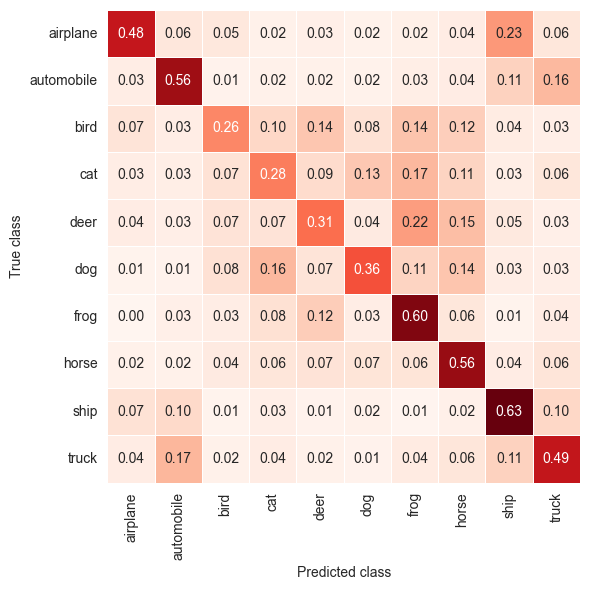

In [28]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

C:\Users\toell\OneDrive\Documents\GitHub\02456-deep-learning-with-PyTorch\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\toell\OneDrive\Documents\GitHub\02456-deep-learning-with-PyTorch\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\toell\OneDrive\Documents\GitHub\02456-deep-learning-with-PyTorch\venv\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\toell\OneDrive\Documents\GitHub\02456-deep-learning-with-PyTorch\venv\l

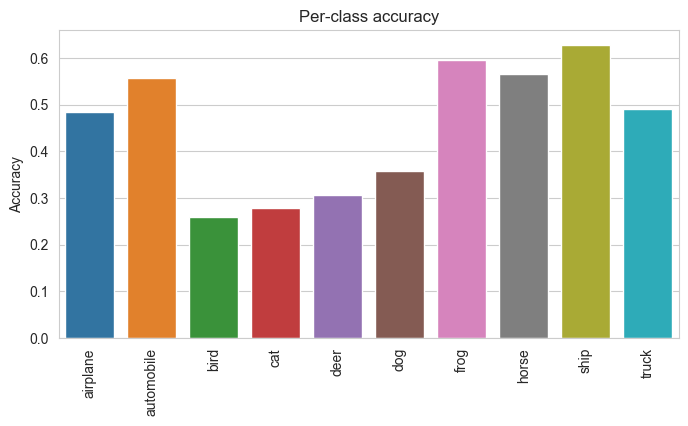

In [29]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.

**Answer:**
By simply following the exercise guide: lots of layers and lots of training I achieved the results shown here.

# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [ ]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

**Answer:**
Question: Earlier in the book we met another type of neuron known as a rectified linear unit. Explain why such neurons don't satisfy the conditions just given for universality. Find a proof of universality showing that rectified linear units are universal for computation.
Answer: Because ReLU is non-differentiable at 0 and is unbounded in the positive direction which violates the conditions for universality.
ReLU functions can, when combined, approximate an arbitrary step-function with arbitrary accuracy due to the way they can partition the function-space into smaller bits


